# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

In [2]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines_averaged(img, lines, color=[255, 0, 0], thickness=4):
    rightLinesX = []
    rightLinesY = []
    leftLinesX = []
    leftLinesY = []
    
    middleX = img.shape[1]/2 
    maxX = img.shape[1]
    maxY = img.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0:
                if (x1 > middleX or x2 > middleX):
                    leftLinesX.append(x1)
                    leftLinesX.append(x2)
                    leftLinesY.append(y1)
                    leftLinesY.append(y2)
            else:
                if (x1 < middleX or x2 < middleX):
                    rightLinesX.append(x1)
                    rightLinesX.append(x2)
                    rightLinesY.append(y1)
                    rightLinesY.append(y2)
    
    if leftLinesX and rightLinesX:
        leftLine = np.polyfit(leftLinesX,leftLinesY,1)
        leftLineBottomPointX = (maxY - leftLine[1])/leftLine[0]
    
        rightLine = np.polyfit(rightLinesX,rightLinesY,1)
        rightLineBottomPointX = (maxY - rightLine[1])/rightLine[0]
    
        xIntersect = (rightLine[1] - leftLine[1])/(leftLine[0] - rightLine[0])
        yIntersect = (leftLine[0]*xIntersect) + leftLine[1]
        
        xIntersect = int(xIntersect)
        yIntersect = int(yIntersect)
        
        cv2.line(img, (int(leftLineBottomPointX), maxY), (xIntersect, yIntersect), color, thickness)
        cv2.line(img, (int(rightLineBottomPointX), maxY), (xIntersect, yIntersect), color, thickness)
    
def draw_lines(img, lines, color=[0, 255, 0], thickness=4):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, challengeMode):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if challengeMode:
        draw_lines_improved(line_img, lines)
    else:
        draw_lines_averaged(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



In [3]:
def findLinesOnImage(image, challengeMode = False):
    lineImage = findLines(image, challengeMode)
    combinedImage = weighted_img(lineImage, image)
    
    return combinedImage

def findLines(image, challengeMode):
    image = imageGradient(image)
    if challengeMode:
        image = maskTopHalfOfImage(image)
    else:
        image = maskImage(image)
    image = imageLines(image, challengeMode)
    
    return image

def imageGradient(image):
    image = grayscale(image)
    image = gaussian_blur(image, 3)
    image = canny(image, 50, 150)
    
    return image

def maskImage(image):
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(460, 310), (500, 310), (900,imshape[0])]], dtype=np.int32)
    image = region_of_interest(image, vertices)
    
    return image

def imageLines(image, challengeMode):
    distanceResolution = 2
    angularResolution = 3*(np.pi/180)
    intersectionThreshold = 10
    min_line_length = 40
    max_line_gap = 15
    
    image = hough_lines(image, distanceResolution, angularResolution, intersectionThreshold, min_line_length, max_line_gap, challengeMode)
    
    return image

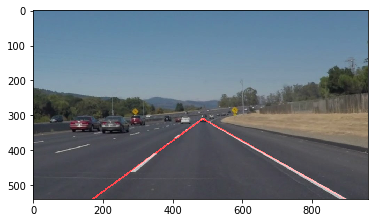

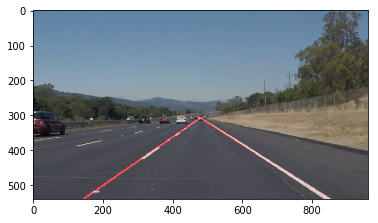

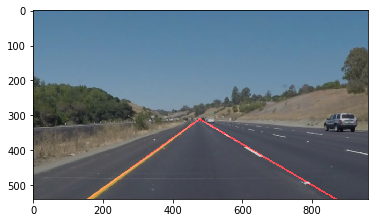

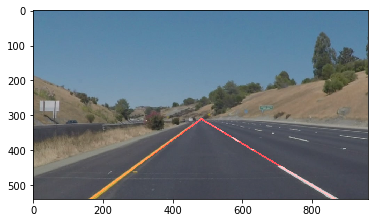

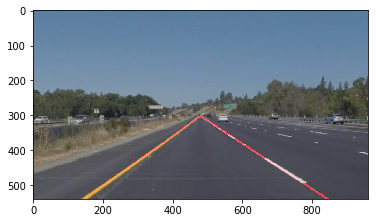

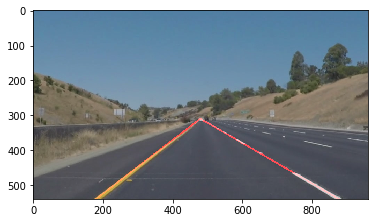

In [4]:
import os
images = os.listdir("test_images/")

for i in range(len(images)):
    image = mpimg.imread('test_images/'+images[i])
    image = findLinesOnImage(image)

    plt.figure()
    plt.imshow(image, cmap='gray')
    
    #plt.savefig('solution_videos/pipeline_improvement/test')
    

## Test on Videos

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    return findLinesOnImage(image)

In [7]:
white_output_simple = 'solution_videos/solidWhiteRightSimple.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")#.subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output_simple, audio=False)

[MoviePy] >>>> Building video solution_videos/solidWhiteRightSimple.mp4
[MoviePy] Writing video solution_videos/solidWhiteRightSimple.mp4


100%|█████████▉| 221/222 [00:05<00:00, 34.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solution_videos/solidWhiteRightSimple.mp4 

CPU times: user 2.26 s, sys: 361 ms, total: 2.62 s
Wall time: 6.87 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output_simple))

In [9]:
yellow_output_simple = 'solution_videos/solidYellowLeftSimple.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output_simple, audio=False)

[MoviePy] >>>> Building video solution_videos/solidYellowLeftSimple.mp4
[MoviePy] Writing video solution_videos/solidYellowLeftSimple.mp4


100%|█████████▉| 681/682 [00:18<00:00, 36.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solution_videos/solidYellowLeftSimple.mp4 

CPU times: user 7.17 s, sys: 1.14 s, total: 8.31 s
Wall time: 19.4 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output_simple))

## Optional Challenge

Here is the code that attempts (and ultimately fails) to handle the challenge video.

In [11]:
def draw_lines_improved(img, lines, color=[255, 0, 0], thickness=4):    
    maxX = img.shape[1]
    maxY = img.shape[0]
    
    filteredLines = getRelevantLines(lines,maxX,maxY)
    
    for line in filteredLines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def getRelevantLines(lines,maxX,maxY):
    lines = transformToSlope(lines)
    lines = filterSlopes(lines,0.4)
    lines = filterSimilarLines(lines, maxY)
    lines = findLineIntersects(lines,maxX,maxY)
    
    return lines

def transformToSlope(lines):
    transformedLines = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            yIntersect = y2 - (slope * x2)
            
            transformedLines.append([slope,yIntersect])
    
    return transformedLines

def filterSlopes(lines,minSlope):
    filteredLines = []
    
    for line in lines:
        slope = line[0]
        yIntersect = line[1]
        if abs(slope) >= minSlope:
            filteredLines.append([slope,yIntersect])
    
    return filteredLines

def filterSimilarLines(lines, maxY, slopeLimit=.2, yIntersectLimit=20):
    filteredLines = []
    lines.sort()
    
    similarLinesGroup = []
    for i in range(len(lines)):
        if i == len(lines)-1:
            if similarLinesGroup:
                filteredLines.append(similarLinesGroup)
            break
        
        slope = lines[i][0]
        nextSlope = lines[i+1][0]
        
        yIntersect = lines[i][1]
        nextyIntersect = lines[i+1][1]
        
        if abs(slope - nextSlope) > slopeLimit:
            if similarLinesGroup:
                filteredLines.append(similarLinesGroup)
            similarLinesGroup = []
            continue
        
        if abs(yIntersect - nextyIntersect) > yIntersectLimit:
            if similarLinesGroup:
                filteredLines.append(similarLinesGroup)
            similarLinesGroup = []
            continue
        
        similarLinesGroup.append(lines[i])
        
    if not filteredLines:
        return filteredLines
        
    bestFiltered = findTwoWithLargestCount(filteredLines)
    
    return bestFiltered

def findTwoWithLargestCount(lines):
    biggestCount = 0
    secondBiggestCount = 0
    biggest = 0
    second = 0
    for i in range(len(lines)):
        count = len(lines[i])
        if count > biggestCount:
            secondBiggestCount = biggestCount
            second = biggest
            biggestCount = count
            biggest = i
        else:
            if count > secondBiggestCount:
                secondBiggestCount = count
                second = i
    
    bestFiltered = []
    bestFiltered.append(lines[biggest])
    bestFiltered.append(lines[second])
    
    return bestFiltered

def findLineIntersects(lines,maxX,maxY):
    linePoints = []
    
    for group in lines:
        for line in group:
            slope = line[0]
            yIntersect = line[1]
            if slope < 0:
                yPoint1 = maxY
            else:
                yPoint1 = 0
            xPoint1 = (yPoint1 - yIntersect)/slope

            xPoint2 = maxX
            yPoint2 = slope * xPoint2 + yIntersect
            linePoints.append([[makeInt(xPoint1), makeInt(yPoint1), makeInt(xPoint2), makeInt(yPoint2)]])
    
    return linePoints

def makeInt(number):
    if math.isnan(number):
        number = 0
    if number >= 6666666666 or math.isinf(number):
        number = 666666666
    return int(number)

def maskTopHalfOfImage(image):
    ratioToMask = 1.7
    imshape = image.shape
    vertices = np.array([[(imshape[1],imshape[0]/ratioToMask),(imshape[1], imshape[0]), (0, imshape[0]), (0,imshape[0]/ratioToMask)]], dtype=np.int32)
    image = region_of_interest(image, vertices)
    
    return image

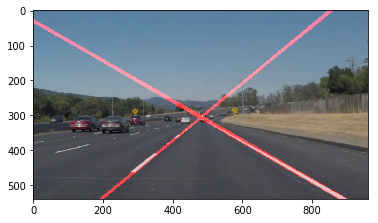

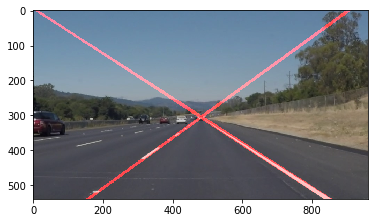

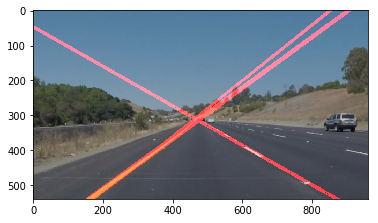

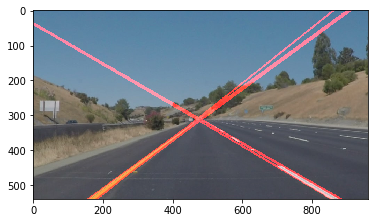

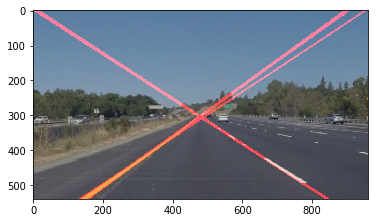

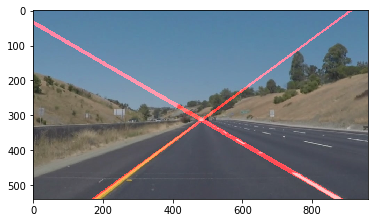

In [20]:
import os
images = os.listdir("test_images/")

for i in range(len(images)):
    image = mpimg.imread('test_images/'+images[i])
    image = findLinesOnImage(image, True)

    plt.figure()
    plt.imshow(image, cmap='gray')
    
    plt.savefig('solution_videos/pipeline_improvement/test')

In [13]:
def process_image(image):
    return findLinesOnImage(image, True)

In [14]:
white_output = 'solution_videos/solidWhiteRightImproved.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")#.subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video solution_videos/solidWhiteRightImproved.mp4
[MoviePy] Writing video solution_videos/solidWhiteRightImproved.mp4


100%|█████████▉| 221/222 [00:06<00:00, 33.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solution_videos/solidWhiteRightImproved.mp4 

CPU times: user 2.84 s, sys: 482 ms, total: 3.32 s
Wall time: 7.65 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [16]:
yellow_output = 'solution_videos/solidYellowLeftImproved.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video solution_videos/solidYellowLeftImproved.mp4
[MoviePy] Writing video solution_videos/solidYellowLeftImproved.mp4


100%|█████████▉| 681/682 [00:21<00:00, 33.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solution_videos/solidYellowLeftImproved.mp4 

CPU times: user 9.02 s, sys: 1.38 s, total: 10.4 s
Wall time: 22.5 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [18]:
challenge_output = 'solution_videos/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video solution_videos/challenge.mp4
[MoviePy] Writing video solution_videos/challenge.mp4


100%|██████████| 251/251 [00:14<00:00, 16.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solution_videos/challenge.mp4 

CPU times: user 6.61 s, sys: 1.68 s, total: 8.3 s
Wall time: 16.6 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))